Epoch 1/5 - Loss: 12.5852
Epoch 2/5 - Loss: 14.5589
Epoch 3/5 - Loss: 13.8763
Epoch 4/5 - Loss: 21.2319
Epoch 5/5 - Loss: 11.2022
Epoch 1/5 - Loss: 110.1796
Epoch 2/5 - Loss: 104.2475
Epoch 3/5 - Loss: 88.8526
Epoch 4/5 - Loss: 86.0607
Epoch 5/5 - Loss: 72.6910
Epoch 1/5 - Loss: 47.9244
Epoch 2/5 - Loss: 24.5128
Epoch 3/5 - Loss: 16.6590
Epoch 4/5 - Loss: 14.7311
Epoch 5/5 - Loss: 13.1294
Epoch 1/5 - Loss: 17.2085
Epoch 2/5 - Loss: 12.7417
Epoch 3/5 - Loss: 13.9374
Epoch 4/5 - Loss: 11.9934
Epoch 5/5 - Loss: 10.4308
Epoch 1/5 - Loss: 33.4816
Epoch 2/5 - Loss: 18.8842
Epoch 3/5 - Loss: 14.6866
Epoch 4/5 - Loss: 13.4998
Epoch 5/5 - Loss: 11.8801
Epoch 1/5 - Loss: 18.9049
Epoch 2/5 - Loss: 14.7310
Epoch 3/5 - Loss: 12.8678
Epoch 4/5 - Loss: 12.8066
Epoch 5/5 - Loss: 12.4945
Epoch 1/5 - Loss: 18.3532
Epoch 2/5 - Loss: 13.9039
Epoch 3/5 - Loss: 12.5091
Epoch 4/5 - Loss: 11.4235
Epoch 5/5 - Loss: 11.3227
Epoch 1/5 - Loss: 18.7645
Epoch 2/5 - Loss: 14.2520
Epoch 3/5 - Loss: 13.9250
Epoch 4/5 

/home/tanglongbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tanglongbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


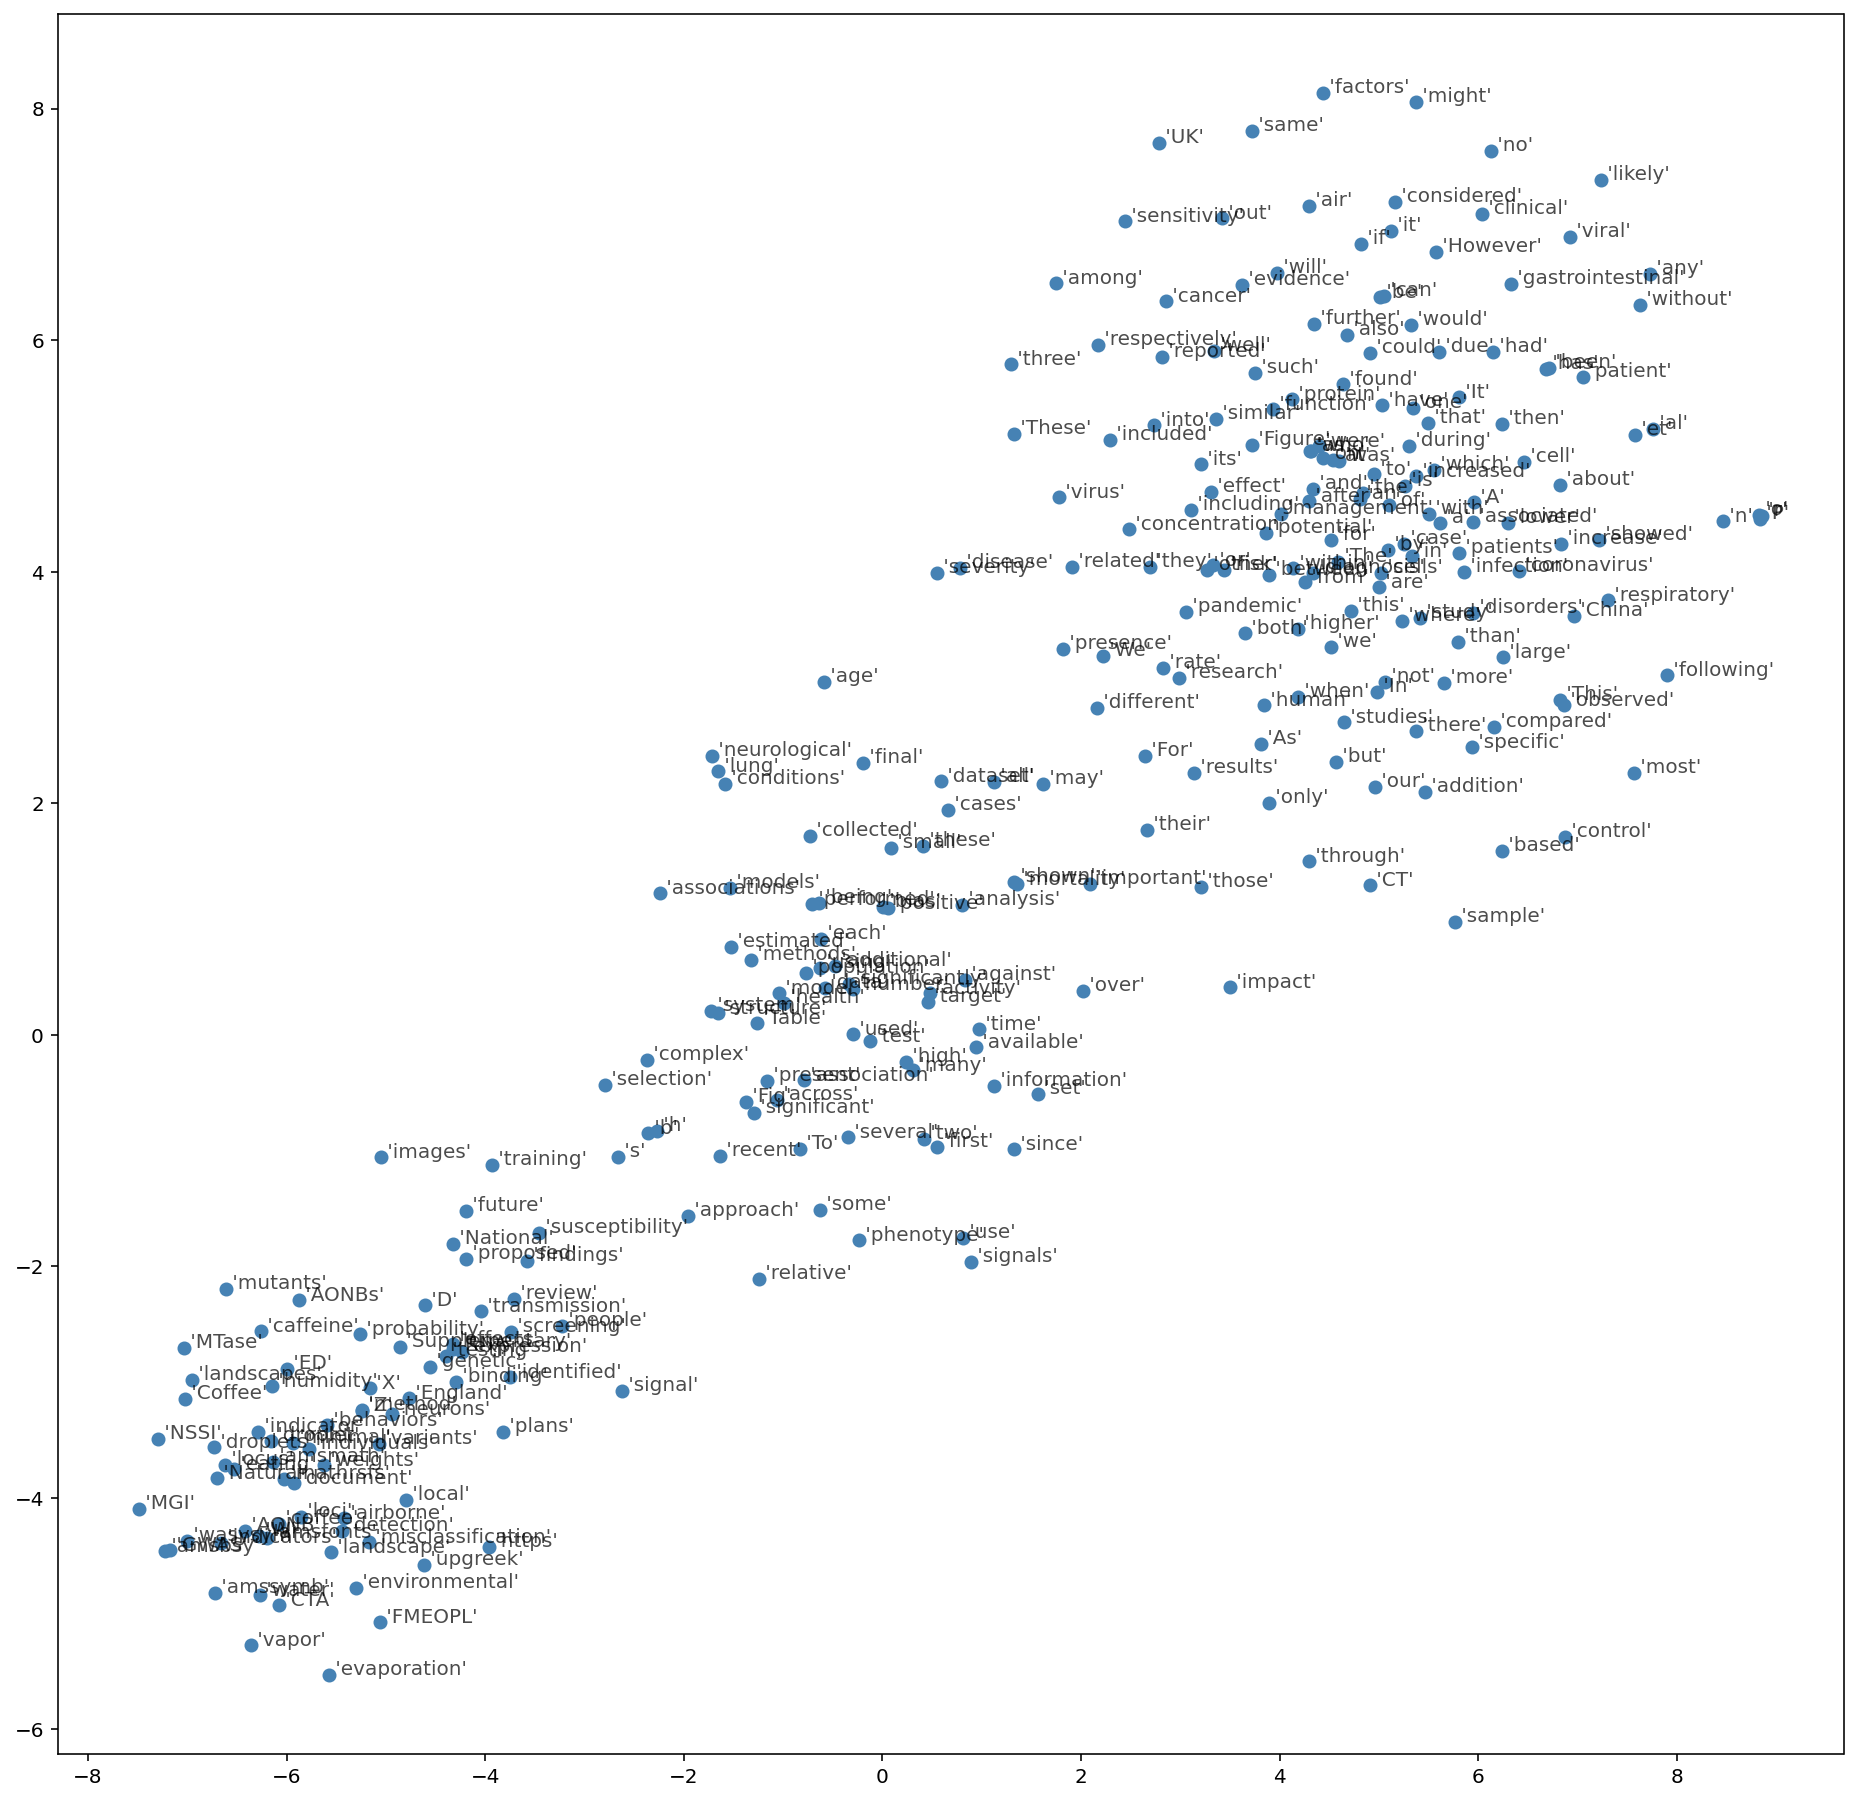

In [2]:
import os
import torch
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# 分词文件夹目录
TokensDirPath = "/home/tanglongbin/NLP/nltk_text"
# 作为词汇表的Tokens文件数量
TokensFileNum = 20
# 词汇量
VocabSize = 10000

# 文章目录（split_text目录）
TextDirPath = "/home/tanglongbin/NLP/split_text"
# 用于训练的文章数量
TextNum = 20
# 每篇文章训练的次数
EpochsNum = 5
# 中心词一侧Positive单词的数量
WindowSize = 5
# Negative单词的数量
NegaNum = 2
# 词向量Feature维度
EmbedSize = 256

# 单次训练使用的数量（可更具内存/显卡负载进行调整）
Batch_Size = 128
# 学习速率（步长）
LearningRate = 0.01



# 获取指定文件夹内的所有文件的绝对路径
# return type: List
def GetFilePath(DirPath):
    
    Res = []
    for FilePath, DirNames, FileNames in os.walk(DirPath):
        for FileName in FileNames:
            str_tmp = os.path.join(FilePath, FileName)
            Res.append(str_tmp)
            
    return Res


# 获取Vocabulary
# 返回设定词汇量的vocab字典
def GetVocab():
    TmpList = []
    TokensFiles = GetFilePath(TokensDirPath)
    for i in range(TokensFileNum):
        with open(TokensFiles[i], 'r') as f:
            S = str(f.readlines())
            # String to List
            L = S.strip('[').strip(']').split(',')
            TmpList += L
    
    # 获取频率最高的VocabSize-1个单词，并将剩下的单词归类为'<unk>'
    Vocab = dict(Counter(TmpList).most_common(VocabSize-1))
    Vocab["<unk>"] = len(TmpList) - np.sum(list(Vocab.values()))
    
    return Vocab


# 对Vocab里的单词进行编码和词频处理
def AnalyzeVocab(Vocab):
    # encoder & decoder
    idx_to_word = [word for word in Vocab.keys()] 
    word_to_idx = {word:i for i, word in enumerate(idx_to_word)}
    
    # 词频变换 
    word_counts = np.array([count for count in Vocab.values()], dtype=np.float32)
    word_freqs = word_counts / np.sum(word_counts)
    word_freqs = word_freqs ** (3./4.)
    word_freqs = word_freqs / np.sum(word_freqs)  # 用来做 negative sampling
    
    return word_to_idx, idx_to_word, word_freqs


# 创建Dataset, 并对文章进行编码
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, text, word_to_idx, idx_to_word, word_freqs):
        super(Dataset, self).__init__()
        # 编码文章
        self.text_encoded = [word_to_idx.get(word, word_to_idx["<unk>"]) for word in text]
        self.word_to_idx = word_to_idx 
        self.idx_to_word = idx_to_word
        # 转换为Tensor以便于GPU训练
        self.text_encoded = torch.Tensor(self.text_encoded).long()
        self.word_freqs = torch.Tensor(word_freqs)
        
    def __len__(self):
        return len(self.text_encoded)
    
    def __getitem__(self, idx):
        ''' 这个function返回以下数据用于训练
            - 中心词
            - 这个单词附近的(positive)单词
            - 随机采样的K个单词作为negative sample
        '''
        center_word = self.text_encoded[idx] 
        pos_indices = list(range(idx-WindowSize, idx)) + list(range(idx + 1, idx + WindowSize + 1))
        pos_indices = [i % len(self.text_encoded) for i in pos_indices]
        pos_words = self.text_encoded[pos_indices]
        # replacement=False无放回的取
        neg_words = torch.multinomial(self.word_freqs, (NegaNum + 1) * pos_words.shape[0], replacement=False)
        # Neg_words 与 pos_words 取差集，确保 neg_words 中不包含 pos_words
        neg_words = np.setdiff1d(neg_words.numpy(), pos_words.numpy())
        neg_words = neg_words[:NegaNum * pos_words.shape[0]]
        neg_words = torch.Tensor(neg_words)
    
        return center_word, pos_words, neg_words 


# Skip-Gram Model
class EmbeddingModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(EmbeddingModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        # 模型建立 & 初始化
        self.embed = torch.nn.Embedding(vocab_size, embed_size)
        initrange = 0.5 / embed_size
        self.embed.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, input_labels, pos_labels, neg_labels):
        '''
        input_labels: 中心词,         [batch_size]
        pos_labels: 中心词周围词       [batch_size * (WindowSize * 2)]
        neg_labelss: 中心词负采样单词  [batch_size, (WindowSize * 2 * NegaNum)]
        return: loss, 返回loss        [batch_size]
        '''
        
        # 编码
        input_embedding = self.embed(input_labels)
        input_embedding = input_embedding.unsqueeze(dim = 2)
        pos_embedding = self.embed(pos_labels)
        neg_embedding = self.embed(neg_labels)
        

        # torch.bmm()为batch间的矩阵相乘（b,n.m)*(b,m,p)=(b,n,p)
        loss_pos = torch.bmm(pos_embedding, input_embedding).squeeze()
        loss_neg = torch.bmm(neg_embedding, -input_embedding).squeeze()
        
        # loss计算
        loss_pos = loss_pos.sigmoid().log().sum(dim = 1)
        loss_neg = loss_neg.sigmoid().log().sum(dim = 1)
        loss = (loss_pos + loss_neg).mean(dim = 0)
        return -loss
    
    def Embeddings(self):
        return self.embed.weight.data.cpu().numpy()


def StartTest(Model, word_to_idx, idx_to_word):
    TestWords = ["and", "am", "where", "bad"]
    
    W = Model.embed.weight.data.clone()
    norm = W.norm(dim = 1).unsqueeze(dim = 1)
    
    W = W/norm
    
    ids = [word_to_idx.get(word, word_to_idx["<unk>"]) for word in TestWords]
    
    x = W[ids]
    
    similarity = torch.mm(x, W.T)
    
    for i in range(len(TestWords)) :
        topk = (-similarity[i,:]).argsort()[:5]
        topk = [idx_to_word[j.item()] for j in topk]
        print(TestWords[i], topk)
    
    return


def  StartTraining():
    
    # 获取Vocab
    Vocab = GetVocab()
    # 获得Vocab分析数据
    word_to_idx, idx_to_word, word_freqs = AnalyzeVocab(Vocab)
    
    # 创建模型(使用Adam算法)
    Model = EmbeddingModel(VocabSize, EmbedSize)
    if torch.cuda.is_available():
        # 若支持cuda加速则使用GPU训练
        Model = Model.cuda()
    Optimizer = torch.optim.Adam(Model.parameters(), lr = LearningRate)
    
    
    
    # 读取Text
    TextFiles = GetFilePath(TextDirPath)
    for i in range(TextNum):
        with open(TextFiles[i]) as f:
            S = str(f.readlines())
            # String to List
            Text = S.strip('[').strip(']').split(',')
            
            # 创建DataLoader
            dataset = Dataset(Text, word_to_idx, idx_to_word, word_freqs)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size = Batch_Size, shuffle = True, num_workers = 8)
            
            # StartTraining
            for j in range(EpochsNum):
                for k, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
                    # 转换为 long int 类型
                    input_labels = input_labels.long()
                    pos_labels = pos_labels.long()
                    neg_labels = neg_labels.long()
                    if torch.cuda.is_available(): 
                        # 若支持cuda加速则使用GPU训练
                        input_labels = input_labels.cuda()
                        pos_labels = pos_labels.cuda()
                        neg_labels = neg_labels.cuda()

                    loss = Model(input_labels, pos_labels, neg_labels)
                    Optimizer.zero_grad()
                    loss.backward()
                    Optimizer.step()
        
                print(f'Epoch {j+1}/{EpochsNum} - Loss: {loss.item():.4f}')
            # StartTest(Model, word_to_idx, idx_to_word)
    embedding_weights = Model.Embeddings()

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

    # from IPython import get_ipython
    # get_ipython().run_line_magic('matplotlib', 'inline')

    viz_words = 300
    tsne = TSNE()
    embed_tsne = tsne.fit_transform(embedding_weights[:viz_words, :])

    fig, ax = plt.subplots(figsize=(16, 16))
    for idx in range(viz_words):
        plt.scatter(*embed_tsne[idx, :], color='steelblue')
        plt.annotate(idx_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    
    return


def main():
    
    # 开始训练
    StartTraining()
    
    return


if __name__ == '__main__':
    main()